<h1>A. Data Collection & Exploration

<h2>Import libraries

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from pylift import TransformedOutcome
from pylift.generate_data import dgp
from pylift.eval import UpliftEval
from sklearn.cluster import KMeans
from statistics import mean
import sklearn.metrics

<h2>Import dataset

In [2]:
df_data = pd.read_csv('turnover.csv', encoding = "ISO-8859-1")
df_data.index.name = "id"
df_model = df_data.copy()

<h2>Define Cols

In [3]:
#choose the single dependent variable (Positive Outcome)
treat = 'coach'

In [4]:
#choose the treatment variable
target = "event"

In [5]:
#choose a column with hiearchy to be label encoded
label_cols=[treat]

In [6]:
#choose a column with wide range to be clusterred
cluster_cols = ['stag']

<h2>Check uniques for categorical data

In [7]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_data[obj].unique():
        print("{} {}".format(unique,sum(df_data[obj] == unique)))


 gender
m 276
f 853

 industry
Banks 114
PowerGeneration 38
Retail 289
manufacture 145
Consult 74
State 55
etc 94
Building 41
IT 122
 HoReCa 11
Telecom 36
Pharma 20
Mining 24
transport 38
Agriculture 15
RealEstate 13

 profession
HR 757
Commercial 23
Marketing 31
etc 37
Sales 66
BusinessDevelopment 27
Finanñe 17
Teaching 12
manage 22
IT 74
Law 7
Consult 25
Engineer 15
PR 6
Accounting 10

 traffic
rabrecNErab 211
empjs 248
youjs 318
referal 95
advert 33
KA 67
recNErab 39
friends 118

 coach
no 683
yes 132
my head 314

 head_gender
f 545
m 584

 greywage
white 1002
grey 127

 way
bus 681
car 331
foot 117


<h1>B. Data Preprocessing

<h2>Label encoding hierarchy columns

In [8]:
#Label encoding
print("label encoding columns:",label_cols)
label_encoder = LabelEncoder()
for col in label_cols:
    df_model[col] = label_encoder.fit_transform(df_data[col])
    df_model[col] = label_encoder.transform(df_data[col])
print(">>label encoding finished")

label encoding columns: ['coach']
>>label encoding finished


<h2>Data cleaning

In [9]:
#remove unused columns
###
#remove unused rows
df_model = df_model.loc[df_model[treat] <=1]
#rename target column to 'Stay'
df_model = df_model.rename(columns={target: "Stay"})
df_data = df_data.rename(columns={target: "Stay"})

<h2>Cluster & One Hot Encoding

In [10]:
#function to order clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [11]:
[col for col in df_model.columns if df_model[col].dtype == "float64"]

['stag',
 'age',
 'extraversion',
 'independ',
 'selfcontrol',
 'anxiety',
 'novator']

In [12]:
#preparing float columns to cluster
print('Clustering columns:',cluster_cols)
#creating the clusters
for col in cluster_cols:
    col_cluster = col + "_cluster"
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(df_model[[col]])
    df_model[col_cluster] = kmeans.predict(df_model[[col]])
    #order the clusters
    df_model = order_cluster(col_cluster, col, df_model, True)
print('>>Cluster succeeded!')
#dropping columns that have been clustered
df_model = df_model.drop(cluster_cols,axis=1)

#one hot encoding the rest columns
dummies = pd.get_dummies(df_model)
print("\nOne Hot Encoding:",dummies.columns.values)
df_model = dummies
print('>>One Hot Encoding succeeded!')

Clustering columns: ['stag']
>>Cluster succeeded!

One Hot Encoding: ['Stay' 'age' 'coach' 'extraversion' 'independ' 'selfcontrol' 'anxiety'
 'novator' 'stag_cluster' 'gender_f' 'gender_m' 'industry_ HoReCa'
 'industry_Agriculture' 'industry_Banks' 'industry_Building'
 'industry_Consult' 'industry_IT' 'industry_Mining' 'industry_Pharma'
 'industry_PowerGeneration' 'industry_RealEstate' 'industry_Retail'
 'industry_State' 'industry_Telecom' 'industry_etc' 'industry_manufacture'
 'industry_transport' 'profession_Accounting'
 'profession_BusinessDevelopment' 'profession_Commercial'
 'profession_Consult' 'profession_Engineer' 'profession_Finanñe'
 'profession_HR' 'profession_IT' 'profession_Law' 'profession_Marketing'
 'profession_PR' 'profession_Sales' 'profession_Teaching' 'profession_etc'
 'profession_manage' 'traffic_KA' 'traffic_advert' 'traffic_empjs'
 'traffic_friends' 'traffic_rabrecNErab' 'traffic_recNErab'
 'traffic_referal' 'traffic_youjs' 'head_gender_f' 'head_gender_m'
 'greyw

In [13]:
df_model

,Stay,age,coach,extraversion,independ,selfcontrol,anxiety,novator,stag_cluster,gender_f,...,traffic_recNErab,traffic_referal,traffic_youjs,head_gender_f,head_gender_m,greywage_grey,greywage_white,way_bus,way_car,way_foot
0,1,35.0,1,6.2,4.1,5.7,7.1,8.3,0,0,...,0,0,0,1,0,0,1,1,0,0
1,1,35.0,1,6.2,6.2,2.6,4.8,8.3,0,1,...,0,0,0,0,1,0,1,1,0,0
2,1,35.0,1,5.4,7.6,4.9,2.5,6.7,0,1,...,0,0,0,0,1,0,1,1,0,0
3,1,29.0,1,8.6,6.9,2.6,4.0,7.5,0,1,...,0,0,0,1,0,0,1,1,0,0
4,1,28.0,1,8.6,5.5,4.9,4.8,5.2,0,1,...,0,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,1,22.0,1,7.0,4.8,4.9,6.3,7.5,3,1,...,1,0,0,0,1,0,1,1,0,0
993,0,33.0,0,4.6,3.4,6.4,6.3,6.7,3,1,...,0,0,0,0,1,0,1,0,0,1
994,0,34.0,1,3.8,5.5,6.4,4.0,4.4,3,0,...,0,1,0,0,1,0,1,1,0,0
995,1,24.0,1,3.8,6.2,8.0,4.0,2.9,3,0,...,0,1,0,0,1,0,1,1,0,0


<h2>Categorizing target class

Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)
>>Categorizing successfull!


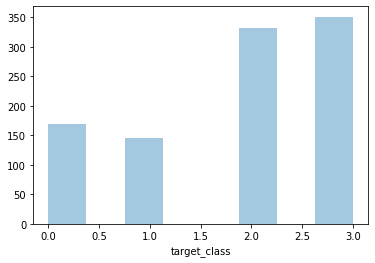

In [14]:
print("Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)")
#to get the CN employees we can simply set the basic value of all data in column target_class equal to 0 
df_model['target_class'] = 0 #CN

#after that we set CR employees with target_class equal to 1 
df_model.loc[(df_model[treat] == 0) & (df_model.Stay > 0),'target_class'] = 1 #CR

#after that we set TN employees with with target_class equal to 2
df_model.loc[(df_model[treat] == 1) & (df_model.Stay == 0),'target_class'] = 2 #TN

#after that we set TR employees with with target_class equal to 3
df_model.loc[(df_model[treat] == 1) & (df_model.Stay > 0),'target_class'] = 3 #TR

print(">>Categorizing successfull!")
sns.distplot(a=df_model.target_class, kde=False)

<h2>Explore data Correlation

In [15]:
#measure the correlation of Employee who stay
pd.options.display.max_rows=100
correlation = df_model.corr(method ='pearson') 
correlation.Stay.sort_values() * 100

industry_IT                       -15.332231
way_foot                          -10.985712
traffic_friends                   -10.708335
profession_HR                     -10.350486
profession_IT                      -7.587150
traffic_youjs                      -7.114859
anxiety                            -6.170444
head_gender_f                      -5.554376
traffic_advert                     -5.284890
greywage_white                     -5.151846
age                                -4.249335
industry_Retail                    -3.591349
industry_Telecom                   -3.434424
industry_PowerGeneration           -3.128780
selfcontrol                        -2.852561
industry_RealEstate                -2.594869
industry_manufacture               -2.421868
stag_cluster                       -2.332834
gender_m                           -1.788994
novator                            -1.621197
industry_transport                 -1.589231
traffic_recNErab                   -0.488037
extraversi

<h2>Create new dataframe for churn and uplift

In [16]:
#duplicate result to df_data for calculating MP & MPU
df_data_churn = df_model[['target_class','Stay',treat]]
print(df_data_churn.head())
# df_data_lift = df_model.copy()
df_data_uplift = df_model[['target_class','Stay',treat]]
print(df_data_uplift.head())

   target_class  Stay  coach
0             3     1      1
1             3     1      1
2             3     1      1
3             3     1      1
4             3     1      1
   target_class  Stay  coach
0             3     1      1
1             3     1      1
2             3     1      1
3             3     1      1
4             3     1      1


<h2>Predicting Target Class(Churn Uplift)

In [17]:
#create feature set and labels
X = df_model.drop(['target_class',treat,'Stay'],axis=1)
y = df_model.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict = xgb_model.predict(df_model.drop(['target_class',treat,'Stay'],axis=1))
overall_proba=xgb_model.predict_proba(df_model.drop(['target_class',treat,'Stay'],axis=1))
# insert predicted target to uplift dataframe
df_data_uplift['p_target'] = overall_predict
df_model['p_target'] = overall_predict
# assign probabilities to 4 different columns
df_data_uplift['proba_CN'] = overall_proba[:,0] 
df_data_uplift['proba_CR'] = overall_proba[:,1] 
df_data_uplift['proba_TN'] = overall_proba[:,2] 
df_data_uplift['proba_TR'] = overall_proba[:,3]
#calculate uplift score for all customers
df_data_uplift['uplift_score'] = df_data_uplift.eval('proba_CN/(proba_CN+proba_CR) + proba_TR/(proba_TN+proba_TR) - proba_TN/(proba_TN+proba_TR) - proba_CR/(proba_CN+proba_CR)')
#assign it back to main dataframe
df_data_uplift['uplift_score'] = df_data_uplift['uplift_score']

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [18]:
df_data_uplift

,target_class,Stay,coach,p_target,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
0,3,1,1,3,0.120726,0.083523,0.270600,0.525150,0.502033
1,3,1,1,3,0.120533,0.089480,0.336676,0.453311,0.295507
2,3,1,1,3,0.082390,0.109838,0.328991,0.478781,0.042651
3,3,1,1,3,0.343014,0.088587,0.164666,0.403733,1.010092
4,3,1,1,3,0.047841,0.197986,0.256963,0.497211,-0.292217
...,...,...,...,...,...,...,...,...,...
992,3,1,1,3,0.111574,0.219508,0.142225,0.526693,0.248756
993,0,0,0,0,0.589190,0.027948,0.225123,0.157739,0.733429
994,2,0,1,2,0.033685,0.112523,0.511753,0.342039,-0.737999
995,3,1,1,3,0.071979,0.263553,0.095378,0.569090,0.141964


<h2>Predicting Target (Churn Prediction)

In [19]:
df_model

,Stay,age,coach,extraversion,independ,selfcontrol,anxiety,novator,stag_cluster,gender_f,...,traffic_youjs,head_gender_f,head_gender_m,greywage_grey,greywage_white,way_bus,way_car,way_foot,target_class,p_target
0,1,35.0,1,6.2,4.1,5.7,7.1,8.3,0,0,...,0,1,0,0,1,1,0,0,3,3
1,1,35.0,1,6.2,6.2,2.6,4.8,8.3,0,1,...,0,0,1,0,1,1,0,0,3,3
2,1,35.0,1,5.4,7.6,4.9,2.5,6.7,0,1,...,0,0,1,0,1,1,0,0,3,3
3,1,29.0,1,8.6,6.9,2.6,4.0,7.5,0,1,...,0,1,0,0,1,1,0,0,3,3
4,1,28.0,1,8.6,5.5,4.9,4.8,5.2,0,1,...,1,0,1,0,1,0,1,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,1,22.0,1,7.0,4.8,4.9,6.3,7.5,3,1,...,0,0,1,0,1,1,0,0,3,3
993,0,33.0,0,4.6,3.4,6.4,6.3,6.7,3,1,...,0,0,1,0,1,0,0,1,0,0
994,0,34.0,1,3.8,5.5,6.4,4.0,4.4,3,0,...,0,0,1,0,1,1,0,0,2,2
995,1,24.0,1,3.8,6.2,8.0,4.0,2.9,3,0,...,0,0,1,0,1,1,0,0,3,3


In [20]:
#create feature set and labels
z = df_model.Stay
#splitting train and test groups
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model2 = xgb.XGBClassifier().fit(X_train, z_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict2 = xgb_model2.predict(df_model.drop(['target_class',treat,'Stay','p_target'],axis=1))
overall_proba2 = xgb_model2.predict_proba(df_model.drop(['target_class',treat,'Stay','p_target'],axis=1))
# df_data_lift = df_model.copy()
df_data_churn['p_stay'] = overall_predict2
df_model['p_stay'] = overall_predict2
df_data_churn['stay_score'] = overall_proba[:,0] 
df_data_churn['churn_score'] = overall_proba[:,1] 

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

<h2>Rank data from Churn prediction

In [21]:
#choose treatment only
df_data_churn = df_data_churn[df_data_churn.coach ==1]
print("Ranking data for Churn Prediction")
df_data_churn = df_data_churn.sort_values(by ='stay_score',ascending=True)
df_data_churn

Ranking data for Churn Prediction


,target_class,Stay,coach,p_stay,stay_score,churn_score
619,2,0,1,0,0.010129,0.012369
426,3,1,1,1,0.011482,0.030633
95,2,0,1,0,0.011827,0.017376
865,2,0,1,1,0.011969,0.010443
141,3,1,1,1,0.012643,0.053503
...,...,...,...,...,...,...
320,2,0,1,0,0.372231,0.068443
62,3,1,1,1,0.385396,0.167081
49,3,1,1,0,0.398842,0.092030
281,2,0,1,0,0.404883,0.061025


In [22]:
df_data_churn = df_data_churn.reset_index()

<h2>Rank data from Uplift prediction

In [23]:
#choose treatment only
df_data_uplift = df_data_uplift[df_data_uplift.coach ==1]
print("Ranking data for Churn Uplift")
df_data_uplift = df_data_uplift.sort_values(by ='uplift_score',ascending=True)
df_data_uplift

Ranking data for Churn Uplift


,target_class,Stay,coach,p_target,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
963,2,0,1,2,0.042180,0.183121,0.722404,0.052294,-1.490559
937,2,0,1,2,0.037218,0.225050,0.552905,0.184827,-1.215117
150,2,0,1,2,0.031720,0.060719,0.844642,0.062919,-1.175046
152,2,0,1,2,0.031720,0.060719,0.844642,0.062919,-1.175046
147,2,0,1,2,0.031720,0.060719,0.844642,0.062919,-1.175046
...,...,...,...,...,...,...,...,...,...
223,3,1,1,3,0.071708,0.031560,0.062931,0.833800,1.248412
169,3,1,1,3,0.111141,0.018478,0.198080,0.672302,1.259732
79,3,1,1,3,0.030782,0.010318,0.093990,0.864910,1.301888
663,3,1,1,3,0.183678,0.053713,0.066050,0.696558,1.374249


In [24]:
df_data_uplift = df_data_uplift.reset_index()

In [25]:
c=0
j=round(len(df_data_churn)/10)
k=round(len(df_model)/10)

#1
b1=200
i1=10
r1_1=(b1-i1-c)
r2_1=(-c)
r3_1=(-i1-c)
r4_1=(b1-c)

#2
b2=100
i2=10
r1_2=(b2-i2-c)
r2_2=(-c)
r3_2=(-i2-c)
r4_2=(b2-c)

#3
b3=100
i3=50
r1_3=(b3-i3-c)
r2_3=(-c)
r3_3=(-i3-c)
r4_3=(b3-c)

profit1=[]
profit2=[]
profit3=[]
profit4=[]
profit5=[]
profit6=[]

uplift1=[]
uplift2=[]
uplift3=[]
uplift4=[]
uplift5=[]
uplift6=[]

churn1=[]
churn2=[]
cum1=[]
cum2=[]
for i in range(10):
    n=i*j
    m=(i+1)*j
    
    #Churn Prediction Variables
    #true predicted churn and retained
    retained = sum((df_data_churn.p_stay[n:m]==0)&(df_data_churn.Stay[n:m]==1))
    #true predicted churn and rejected
    non_retained = sum((df_data_churn.p_stay[n:m]==0)&(df_data_churn.Stay[n:m]==0))
    #false predicted churn
    false = sum((df_data_churn.p_stay[n:m]==0)&(df_data_churn.target_class[n:m]==2))
    
    #Churn Uplift Variables
    CN=sum(df_data_uplift.p_target[n:m]==0)
    CR=sum(df_data_uplift.p_target[n:m]==1)
    TN=sum(df_data_uplift.p_target[n:m]==2)
    TR=sum(df_data_uplift.p_target[n:m]==3)
    
    uplift_retained=sum((df_data_uplift.p_target[n:m]==3)&(df_data_uplift.target_class[n:m]==3))
    uplift_non_retained=sum((df_data_uplift.p_target[n:m]==3)&(df_data_uplift.target_class[n:m]==2))
    uplift_false=CR
    
    #Churn Prediction mp 
    mp1=((retained*r1_1)+(non_retained*r2_1)+(false*r3_1))/j
    mp2=((retained*r1_2)+(non_retained*r2_2)+(false*r3_2))/j
    mp3=((retained*r1_3)+(non_retained*r2_3)+(false*r3_3))/j
    
    #Churn Uplift mp
    mp4=((uplift_retained*r1_1)+(uplift_non_retained*r2_1)+(uplift_false*r3_1))/j
    mp5=((uplift_retained*r1_2)+(uplift_non_retained*r2_2)+(uplift_false*r3_2))/j
    mp6=((uplift_retained*r1_3)+(uplift_non_retained*r2_3)+(uplift_false*r3_3))/j

    profit1.append(mp1)
    profit2.append(mp2)
    profit3.append(mp3)
    profit4.append(mp4)
    profit5.append(mp5)
    profit6.append(mp6)
    
    #Churn Prediction Variables
    CP_lift = sum(df_data_churn[j:]['Stay'] ==1)
    CP_non_lift = sum(df_data_churn[j:]['Stay'] ==0)
    CU_lift = sum(df_data_uplift[j:]['Stay'] ==1)
    CU_non_lift = sum(df_data_uplift[j:]['Stay'] ==0)
    
    #Churn Prediction mpu
    mpu1=((CP_lift*r4_1)-(CP_non_lift*i1))/j
    mpu2=((CP_lift*r4_2)-(CP_non_lift*i2))/j
    mpu3=((CP_lift*r4_3)-(CP_non_lift*i3))/j
    
    #Churn Uplift mpu
    mpu4=((CU_lift*r4_1)-(CU_non_lift*i1))/j
    mpu5=((CU_lift*r4_2)-(CU_non_lift*i2))/j
    mpu6=((CU_lift*r4_3)-(CU_non_lift*i3))/j
        
    uplift1.append(mpu1)
    uplift2.append(mpu2)
    uplift3.append(mpu3)
    uplift4.append(mpu4)
    uplift5.append(mpu5)
    uplift6.append(mpu6)
    
    #employee churn rate
    churn_rate1=(TN)/j    
    churn_rate2=(TN+CN)/j    
    churn1.append(churn_rate1)
    churn2.append(churn_rate2)
    
    #employee cumulative uplift
    cum_uplift_rate1=(CR)/j    
    cum_uplift_rate2=(CR+TR)/j    
    cum1.append(churn_rate1)
    cum2.append(churn_rate2)
    
    print("\ncalculating total employees for Q{}({}-{})".format(i+1,n,m))
    print("CN=",CN)
    print("CR=",CR)
    print("TN=",TN)
    print("TR=",TR)   
    print("CP | MP2=(({}*{})+({}*{})+({}*{}) )/{}={}".format(retained,r1_2,non_retained,r2_2,false,r3_2,j,mp2))
    print("CU | MP2=(({}*{})+({}*{})+({}*{}) )/{}={}".format(uplift_retained,r1_2,uplift_non_retained,r2_2,uplift_false,r3_2,j,mp5))
    print("CP | MPU2=(({}*{})-({}*{}) )/{}={}".format(CP_lift,r4_2,CP_non_lift,r4_2,j,mpu2))
    print("CU | MPU2=(({}*{})-({}*{}) )/{}={}".format(CU_lift,r4_2,CU_non_lift,r4_2,j,mpu5))


calculating total employees for Q1(0-68)
CN= 0
CR= 5
TN= 62
TR= 1
CP | MP2=((3*90)+(20*0)+(20*-10) )/68=1.0294117647058822
CU | MP2=((1*90)+(0*0)+(5*-10) )/68=0.5882352941176471
CP | MPU2=((312*100)-(303*100) )/68=414.2647058823529
CU | MPU2=((342*100)-(273*100) )/68=462.79411764705884

calculating total employees for Q2(68-136)
CN= 0
CR= 4
TN= 54
TR= 10
CP | MP2=((5*90)+(13*0)+(13*-10) )/68=4.705882352941177
CU | MP2=((8*90)+(2*0)+(4*-10) )/68=10.0
CP | MPU2=((312*100)-(303*100) )/68=414.2647058823529
CU | MPU2=((342*100)-(273*100) )/68=462.79411764705884

calculating total employees for Q3(136-204)
CN= 0
CR= 1
TN= 47
TR= 20
CP | MP2=((3*90)+(26*0)+(26*-10) )/68=0.14705882352941177
CU | MP2=((12*90)+(8*0)+(1*-10) )/68=15.735294117647058
CP | MPU2=((312*100)-(303*100) )/68=414.2647058823529
CU | MPU2=((342*100)-(273*100) )/68=462.79411764705884

calculating total employees for Q4(204-272)
CN= 0
CR= 0
TN= 46
TR= 22
CP | MP2=((7*90)+(22*0)+(22*-10) )/68=6.029411764705882
CU | MP2=((16*9

In [26]:
cum_profit1=[]
cum_profit2=[]
cum_profit3=[]
cum_profit4=[]
cum_profit5=[]
cum_profit6=[]
for i in range(1,11):
    cum_profit1.append(sum(profit1[0:i])/i)
for i in range(1,11):
    cum_profit2.append(sum(profit2[0:i])/i)
for i in range(1,11):
    cum_profit3.append(sum(profit3[0:i])/i)
for i in range(1,11):
    cum_profit4.append(sum(profit4[0:i])/i)
for i in range(1,11):
    cum_profit5.append(sum(profit5[0:i])/i)
for i in range(1,11):
    cum_profit6.append(sum(profit6[0:i])/i)
    
cum_uplift1=[]
cum_uplift2=[]
cum_uplift3=[]
cum_uplift4=[]
cum_uplift5=[]
cum_uplift6=[]
for i in range(1,11):
    cum_uplift1.append(sum(uplift1[0:i])/i)
for i in range(1,11):
    cum_uplift2.append(sum(uplift2[0:i])/i)
for i in range(1,11):
    cum_uplift3.append(sum(uplift3[0:i])/i)
for i in range(1,11):
    cum_uplift4.append(sum(uplift4[0:i])/i)
for i in range(1,11):
    cum_uplift5.append(sum(uplift5[0:i])/i)
for i in range(1,11):
    cum_uplift6.append(sum(uplift6[0:i])/i)
    
cum_churn1=[]
cum_churn2=[]
for i in range(10):
    cum_churn1.append(sum(churn1[0:i]))
for i in range(10):
    cum_churn2.append(sum(churn2[0:i]))
    
cum_cum1=[]
cum_cum2=[]
for i in range(10):
    cum_cum1.append(sum(cum1[0:i]))
for i in range(10):
    cum_cum2.append(sum(cum2[0:i]))

Text(0.5, 1.0, 'MP - 1')

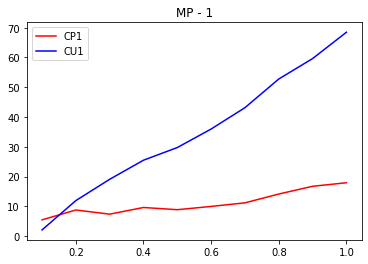

In [27]:
quantile=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
sns.lineplot(x=quantile,y=cum_profit1, label='CP1', color='red')
sns.lineplot(x=quantile,y=cum_profit4, label='CU1', color='blue')
plt.title('MP - 1')

In [28]:
mean_cp=mean(cum_profit2)
mean_cu=mean(cum_profit5)
print("Predictive Method's Avg MaxProfit =", round(mean_cp,2))
print("Our Method's Avg MaxProfit =", round(mean_cu,2))
print("Our method gain {} times more MaxProfit".format(round(mean_cu/mean_cp,2)))

Predictive Method's Avg MaxProfit = 3.46
Our Method's Avg MaxProfit = 16.27
Our method gain 4.71 times more MaxProfit


Text(0, 0.5, 'Profit per customer')

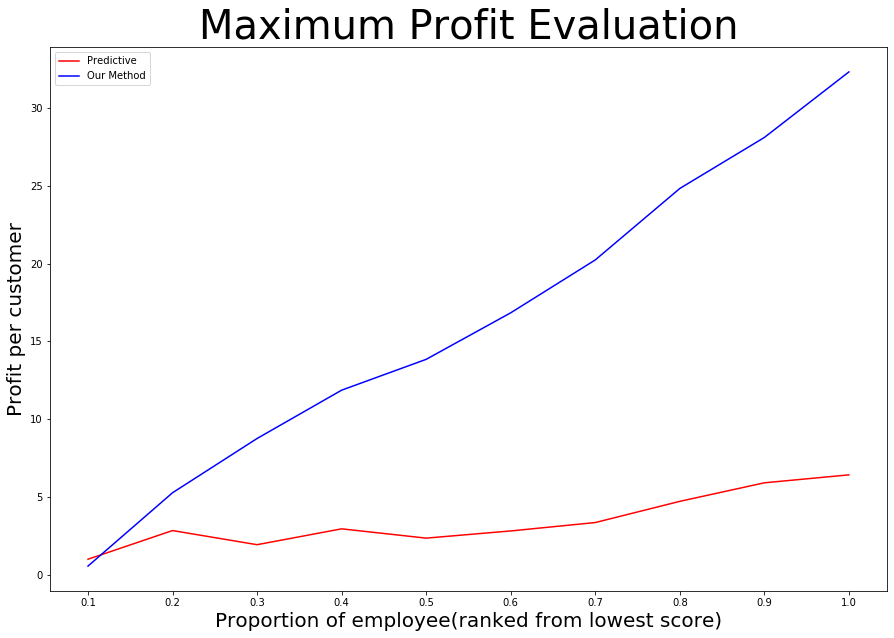

In [29]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_profit2, label='Predictive', color='red')
sns.lineplot(x=quantile,y=cum_profit5, label='Our Method', color='blue')
plt.title('Maximum Profit Evaluation',fontsize=40)
plt.xticks(np.arange(.1,1.1,.1))
plt.xlabel('Proportion of employee(ranked from lowest score)',fontsize=20)
plt.ylabel('Profit per customer',fontsize=20)

Text(0.5, 0, 'Proportion of employee')

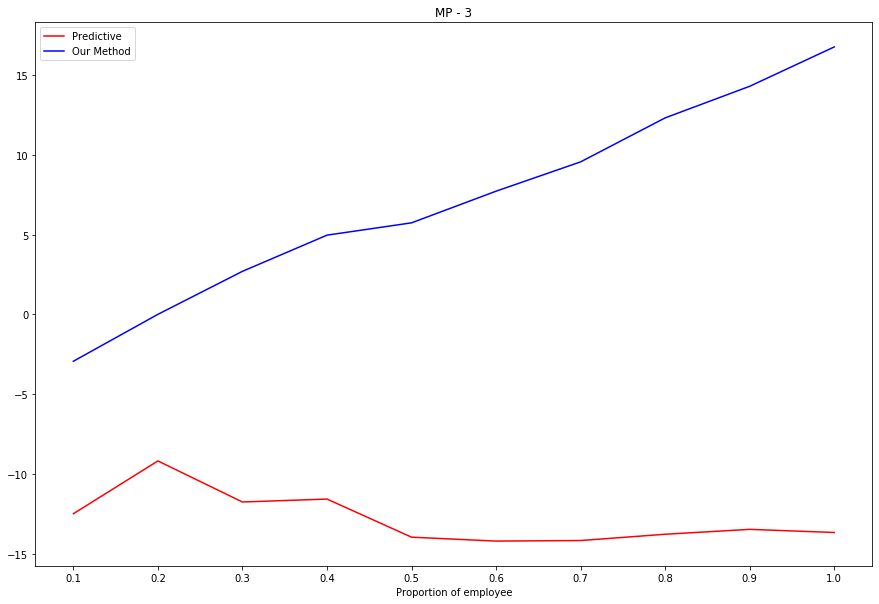

In [30]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_profit3, label='Predictive', color='red')
sns.lineplot(x=quantile,y=cum_profit6, label='Our Method', color='blue')
plt.title('MP - 3')
plt.xticks(np.arange(.1,1.1,.1))
plt.xlabel('Proportion of employee')

Text(0.5, 1.0, 'MP Method')

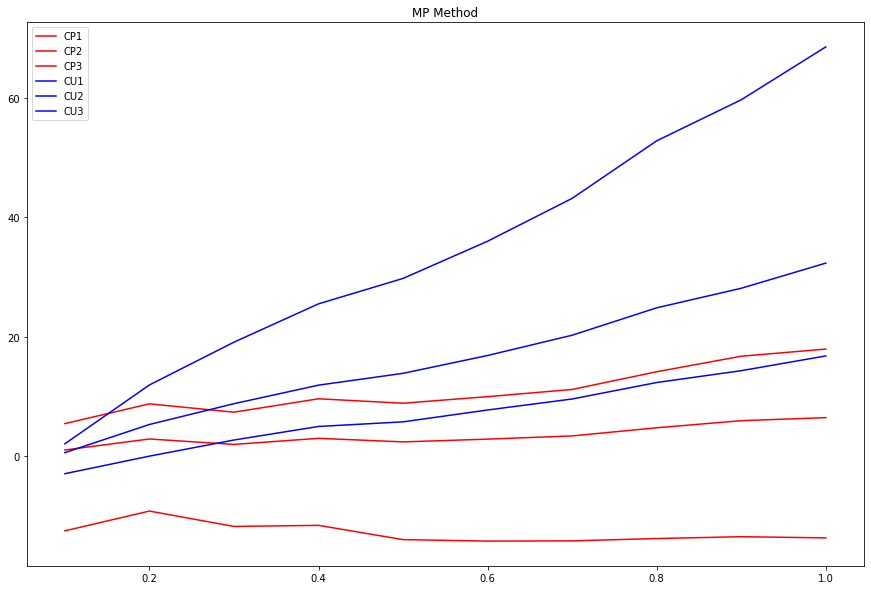

In [31]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_profit1, label='CP1', color='red')
sns.lineplot(x=quantile,y=cum_profit3, label='CP2', color='red')
sns.lineplot(x=quantile,y=cum_profit2, label='CP3', color='red')
sns.lineplot(x=quantile,y=cum_profit4, label='CU1', color='blue')
sns.lineplot(x=quantile,y=cum_profit5, label='CU2', color='blue')
sns.lineplot(x=quantile,y=cum_profit6, label='CU3', color='blue')
plt.title('MP Method')

Text(0.5, 1.0, 'MPU - 1')

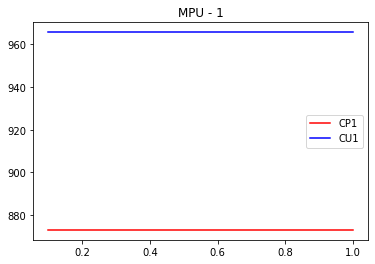

In [32]:
sns.lineplot(x=quantile,y=cum_uplift1, label='CP1', color='red')
sns.lineplot(x=quantile,y=cum_uplift4, label='CU1', color='blue')
plt.title('MPU - 1')

Text(0.5, 1.0, 'MPU - 2')

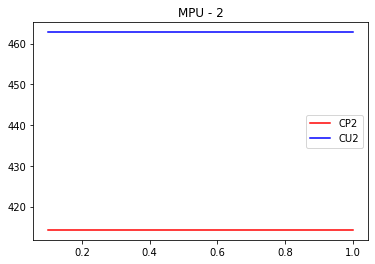

In [33]:
sns.lineplot(x=quantile,y=cum_uplift2, label='CP2', color='red')
sns.lineplot(x=quantile,y=cum_uplift5, label='CU2', color='blue')
plt.title('MPU - 2')

Text(0.5, 1.0, 'MPU - 3')

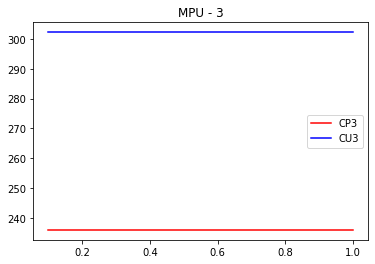

In [34]:
sns.lineplot(x=quantile,y=cum_uplift3, label='CP3', color='red')
sns.lineplot(x=quantile,y=cum_uplift6, label='CU3', color='blue')
plt.title('MPU - 3')

Text(0.5, 1.0, 'MPU Method')

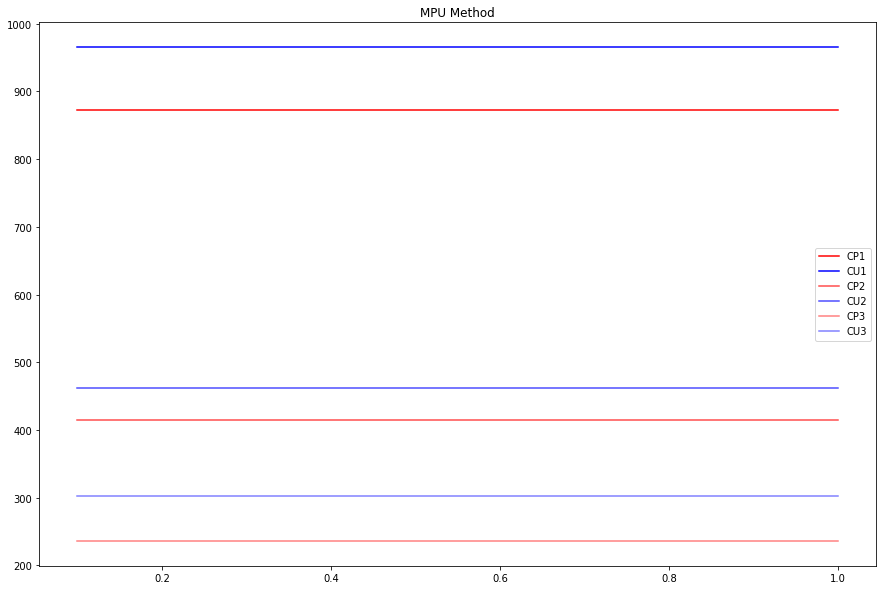

In [35]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_uplift1, label='CP1', color='red')
sns.lineplot(x=quantile,y=cum_uplift4, label='CU1', color='blue')
sns.lineplot(x=quantile,y=cum_uplift2, label='CP2', color='red', alpha=0.7)
sns.lineplot(x=quantile,y=cum_uplift5, label='CU2', color='blue', alpha=0.7)
sns.lineplot(x=quantile,y=cum_uplift3, label='CP3', color='red', alpha=0.5)
sns.lineplot(x=quantile,y=cum_uplift6, label='CU3', color='blue', alpha=0.5)
plt.title('MPU Method')

In [36]:
df_data

,stag,Stay,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
id,,,,,,,,,,,,,,,,
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,10.611910,0,f,41.0,Banks,HR,rabrecNErab,my head,m,white,bus,8.6,3.4,2.6,4.8,8.3
1125,10.611910,0,f,41.0,Banks,HR,rabrecNErab,my head,m,white,bus,8.6,3.4,2.6,4.8,8.3
1126,118.800821,0,f,34.0,Telecom,Accounting,KA,no,f,white,bus,4.6,5.5,7.2,6.3,3.7


<h2>Pylift

In [37]:
df_data_pylift = df_model.copy()
df_data_pylift.drop(['target_class'], axis=1)
df_data_pylift

,Stay,age,coach,extraversion,independ,selfcontrol,anxiety,novator,stag_cluster,gender_f,...,head_gender_f,head_gender_m,greywage_grey,greywage_white,way_bus,way_car,way_foot,target_class,p_target,p_stay
0,1,35.0,1,6.2,4.1,5.7,7.1,8.3,0,0,...,1,0,0,1,1,0,0,3,3,1
1,1,35.0,1,6.2,6.2,2.6,4.8,8.3,0,1,...,0,1,0,1,1,0,0,3,3,1
2,1,35.0,1,5.4,7.6,4.9,2.5,6.7,0,1,...,0,1,0,1,1,0,0,3,3,1
3,1,29.0,1,8.6,6.9,2.6,4.0,7.5,0,1,...,1,0,0,1,1,0,0,3,3,1
4,1,28.0,1,8.6,5.5,4.9,4.8,5.2,0,1,...,0,1,0,1,0,1,0,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,1,22.0,1,7.0,4.8,4.9,6.3,7.5,3,1,...,0,1,0,1,1,0,0,3,3,1
993,0,33.0,0,4.6,3.4,6.4,6.3,6.7,3,1,...,0,1,0,1,0,0,1,0,0,0
994,0,34.0,1,3.8,5.5,6.4,4.0,4.4,3,0,...,0,1,0,1,1,0,0,2,2,1
995,1,24.0,1,3.8,6.2,8.0,4.0,2.9,3,0,...,0,1,0,1,1,0,0,3,3,1


pylift modelling

In [38]:
up = TransformedOutcome(df_model, col_treatment=treat, col_outcome='Stay')

In [39]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=46)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   16.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   50.4s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=1,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                                      16, 17, 18, 19, 20],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                  

In [40]:
up.fit(**up.rand_search_.best_params_)

[19:25:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


No handles with labels found to put in legend.


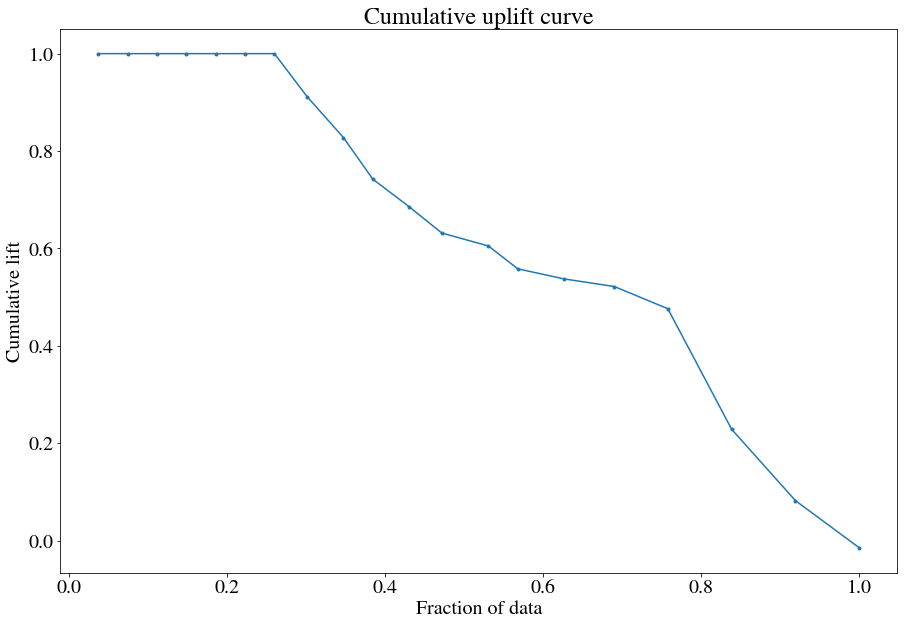

In [41]:
up.plot(plot_type='cuplift')

In [42]:
up.test_results_.q1_cgains

0.5808991488311245

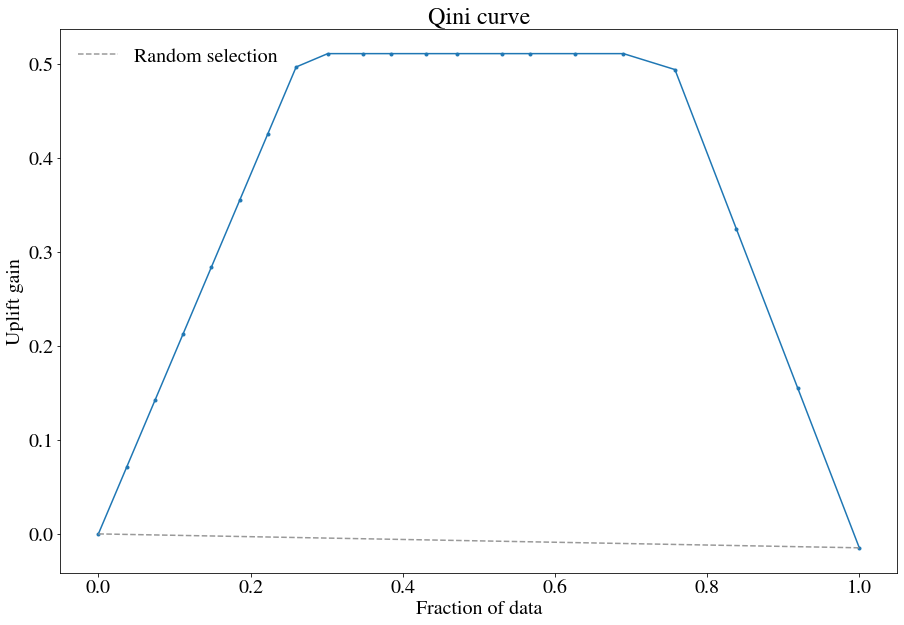

In [43]:
up.plot(plot_type='qini')

[19:25:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 0 finished.
[19:25:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 1 finished.
[19:25:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 2 finished.
[19:25:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 3 finished.
[19:25:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Seed 4 finished.


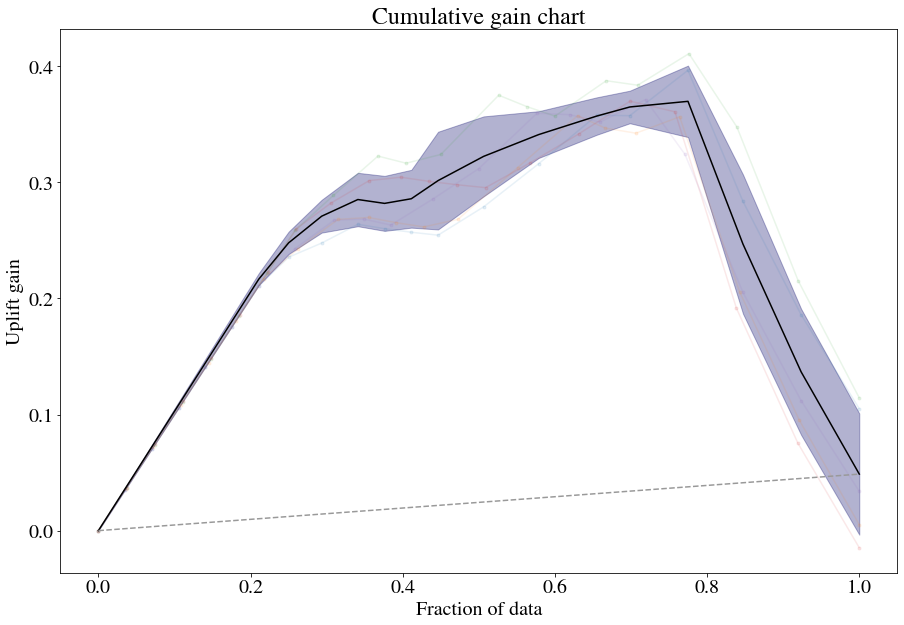

In [44]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);
up.plot(show_shuffle_fits=True)

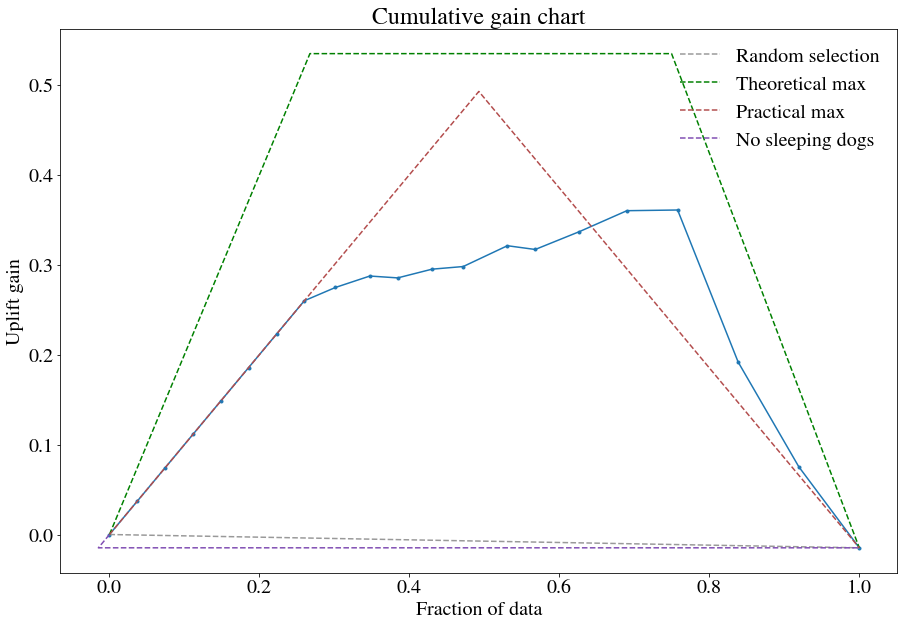

In [45]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

<h1>Causal Lift

In [46]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):
    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df[df[predicted_col] == True]

    rows = []
    for group in np.array_split(subset, 10):
        score = sklearn.metrics.accuracy_score(group[actual_col].tolist(),
                                                   group[predicted_col].tolist(),
                                                   normalize=False)

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
    lift['PercentCorrect'] = lift.apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
        lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
            'NumCorrectPredictions'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

    #Lift Chart
    lift['NormalisedPercentAvg'] = 1
    lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']

    return lift

In [47]:
cum_lift = calc_cumulative_gains(df_data_churn, 'Stay', 'p_stay', 'stay_score')
cum_lift

,NumCases,NumCorrectPredictions,RunningCorrect,PercentCorrect,CumulativeCorrectBestCase,PercentCorrectBestCase,AvgCase,CumulativeAvgCase,PercentAvgCase,NormalisedPercentAvg,NormalisedPercentWithModel
0,34,26,26,9.594096,34,12.546125,27.1,27.1,10.0,1,0.959410
1,34,30,56,20.664207,68,25.092251,27.1,54.2,20.0,1,1.033210
2,34,28,84,30.996310,102,37.638376,27.1,81.3,30.0,1,1.033210
3,34,32,116,42.804428,136,50.184502,27.1,108.4,40.0,1,1.070111
4,34,28,144,53.136531,170,62.730627,27.1,135.5,50.0,1,1.062731
5,34,28,172,63.468635,204,75.276753,27.1,162.6,60.0,1,1.057811
6,34,25,197,72.693727,238,87.822878,27.1,189.7,70.0,1,1.038482
7,34,26,223,82.287823,272,100.000000,27.1,216.8,80.0,1,1.028598
8,33,23,246,90.774908,305,100.000000,27.1,243.9,90.0,1,1.008610
9,33,25,271,100.000000,338,100.000000,27.1,271.0,100.0,1,1.000000


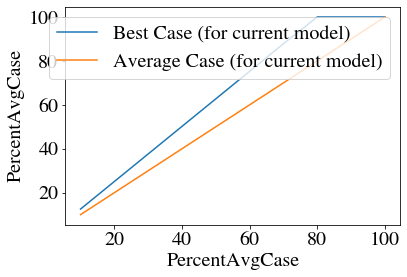

In [48]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_lift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_lift, label="Average Case (for current model)")

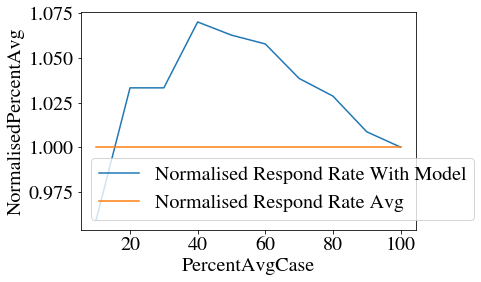

In [49]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_lift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_lift, label="Normalised Respond Rate Avg")

In [50]:
cum_uplift = calc_cumulative_gains(df_data_uplift, 'target_class', 'p_target', 'uplift_score')
cum_uplift

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


,NumCases,NumCorrectPredictions,RunningCorrect,PercentCorrect,CumulativeCorrectBestCase,PercentCorrectBestCase,AvgCase,CumulativeAvgCase,PercentAvgCase,NormalisedPercentAvg,NormalisedPercentWithModel
0,2,0,0,NaN,2,100,0.0,0.0,NaN,1,NaN
1,2,0,0,NaN,4,100,0.0,0.0,NaN,1,NaN
2,2,0,0,NaN,6,100,0.0,0.0,NaN,1,NaN
3,2,0,0,NaN,8,100,0.0,0.0,NaN,1,NaN
4,2,0,0,NaN,10,100,0.0,0.0,NaN,1,NaN
5,2,0,0,NaN,12,100,0.0,0.0,NaN,1,NaN
6,2,0,0,NaN,14,100,0.0,0.0,NaN,1,NaN
7,2,0,0,NaN,16,100,0.0,0.0,NaN,1,NaN
8,1,0,0,NaN,17,100,0.0,0.0,NaN,1,NaN
9,1,0,0,NaN,18,100,0.0,0.0,NaN,1,NaN


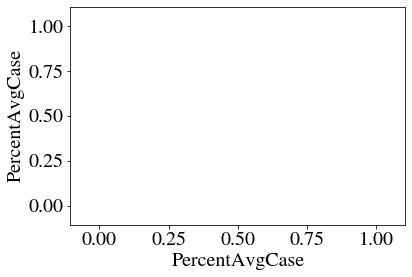

In [51]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_uplift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_uplift, label="Average Case (for current model)")

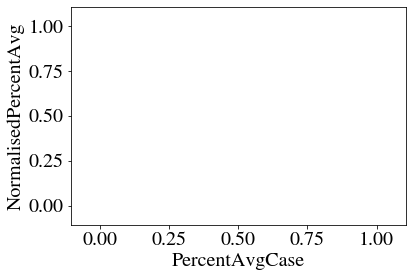

In [52]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_uplift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_uplift, label="Normalised Respond Rate Avg")

In [53]:
#create feature set and labels
df_model_causal = df_model.drop(['target_class','p_stay','p_target'],axis=1)
df_model_causal.rename(columns={treat:'Treatment','Stay':'Outcome'}, inplace=True)
df_model_causal

,Outcome,age,Treatment,extraversion,independ,selfcontrol,anxiety,novator,stag_cluster,gender_f,...,traffic_referal,traffic_youjs,head_gender_f,head_gender_m,greywage_grey,greywage_white,way_bus,way_car,way_foot,TransformedOutcome
0,1,35.0,1,6.2,4.1,5.7,7.1,8.3,0,0,...,0,0,1,0,0,1,1,0,0,1.45974
1,1,35.0,1,6.2,6.2,2.6,4.8,8.3,0,1,...,0,0,0,1,0,1,1,0,0,1.45974
2,1,35.0,1,5.4,7.6,4.9,2.5,6.7,0,1,...,0,0,0,1,0,1,1,0,0,1.45974
3,1,29.0,1,8.6,6.9,2.6,4.0,7.5,0,1,...,0,0,1,0,0,1,1,0,0,1.45974
4,1,28.0,1,8.6,5.5,4.9,4.8,5.2,0,1,...,0,1,0,1,0,1,0,1,0,1.45974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,1,22.0,1,7.0,4.8,4.9,6.3,7.5,3,1,...,0,0,0,1,0,1,1,0,0,1.45974
993,0,33.0,0,4.6,3.4,6.4,6.3,6.7,3,1,...,0,0,0,1,0,1,0,0,1,-0
994,0,34.0,1,3.8,5.5,6.4,4.0,4.4,3,0,...,1,0,0,1,0,1,1,0,0,0
995,1,24.0,1,3.8,6.2,8.0,4.0,2.9,3,0,...,1,0,0,1,0,1,1,0,0,1.45974


In [54]:
#splitting train and test groups
train_df, test_df = train_test_split(df_model_causal, test_size=0.2, random_state=42, stratify=df_model_causal['Treatment'])

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\kedro\io\core.py:682: DeprecationWarning: PickleLocalDataSet will be deprecated in future releases. Please refer to replacement datasets in kedro.extras.datasets.
  DeprecationWarning,
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\kedro\io\core.py:682: DeprecationWarning: CSVLocalDataSet will be deprecated in future releases. Please refer to replacement datasets in kedro.extras.datasets.
  DeprecationWarning,


[2020-02-29 19:26:00,681|causallift.context.flexible_context|INFO] Run pipeline (tags: ['011_bundle_train_and_test_data'], SequentialRunner, only_missing: False)
[2020-02-29 19:26:00,760|kedro.pipeline.node|INFO] Running node: bundle_train_and_test_data([args_raw,test_df,train_df]) -> [df_00]
[2020-02-29 19:26:00,784|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2020-02-29 19:26:00,787|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-02-29 19:26:00,800|causallift.context.flexible_context|INFO] Run pipeline (tags: ['121_prepare_args', '131_treatment_fractions_', '141_initialize_model'], SequentialRunner, only_missing: False)


C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\kedro\pipeline\pipeline.py:198: DeprecationWarning: `name` parameter is deprecated for the `Pipeline` constructor, use `Pipeline.tag` method instead
  DeprecationWarning,


[2020-02-29 19:26:00,846|kedro.pipeline.node|INFO] Running node: treatment_fractions_([args_raw,df_00]) -> [treatment_fractions]
[2020-02-29 19:26:00,906|kedro.runner.sequential_runner|INFO] Completed 1 out of 3 tasks
[2020-02-29 19:26:00,912|kedro.pipeline.node|INFO] Running node: impute_cols_features([args_raw,df_00]) -> [args_intermediate]
[2020-02-29 19:26:00,919|kedro.runner.sequential_runner|INFO] Completed 2 out of 3 tasks
[2020-02-29 19:26:00,947|kedro.pipeline.node|INFO] Running node: schedule_propensity_scoring([args_intermediate,df_00]) -> [args]
[2020-02-29 19:26:00,952|kedro.runner.sequential_runner|INFO] Completed 3 out of 3 tasks
[2020-02-29 19:26:00,955|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-02-29 19:26:00,964|causallift.context.flexible_context|INFO] Run pipeline (tags: ['211_fit_propensity'], SequentialRunner, only_missing: False)
[2020-02-29 19:26:01,008|kedro.pipeline.node|INFO] Running node: fit_propensity([args,df_00]

,age,extraversion,independ,selfcontrol,anxiety,novator,stag_cluster,gender_f,gender_m,industry_ HoReCa,...,traffic_referal,traffic_youjs,head_gender_f,head_gender_m,greywage_grey,greywage_white,way_bus,way_car,way_foot,TransformedOutcome
coefficient,0.093575,-0.076822,-0.140544,0.031567,-0.154664,0.108415,-0.08967,-0.347402,0.0,0.0,...,-0.327464,-0.080916,-0.355675,0.0,0.0,-0.134703,0.0,0.450686,0.0,3.705686


[2020-02-29 19:26:03,654|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2020-02-29 19:26:03,656|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-02-29 19:26:03,678|causallift.context.flexible_context|INFO] Run pipeline (tags: ['221_estimate_propensity'], SequentialRunner, only_missing: False)
[2020-02-29 19:26:03,710|kedro.pipeline.node|INFO] Running node: estimate_propensity([args,df_00,propensity_model]) -> [df_01]
[2020-02-29 19:26:03,746|causallift.nodes.estimate_propensity|INFO] 
### Histogram of propensity score for train and test data:


C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\kedro\pipeline\pipeline.py:198: DeprecationWarning: `name` parameter is deprecated for the `Pipeline` constructor, use `Pipeline.tag` method instead
  DeprecationWarning,


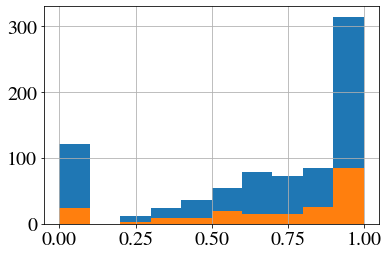

[2020-02-29 19:26:04,152|causallift.nodes.estimate_propensity|INFO] 
### Score Table for logistic regression to calculate propensity score:


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,797,2,0.87202,0.867550,0.959707,0.911304,0.820491,0.685069,0.757842
test,200,2,0.85000,0.840764,0.963504,0.897959,0.783339,0.685000,0.785000


[2020-02-29 19:26:04,211|causallift.nodes.estimate_propensity|INFO] 
### Confusion Matrix for Train:


,Pred_0,Pred_1
True_0,171,80
True_1,22,524


[2020-02-29 19:26:04,230|causallift.nodes.estimate_propensity|INFO] 
### Confusion Matrix for Test:


,Pred_0,Pred_1
True_0,38,25
True_1,5,132


[2020-02-29 19:26:04,298|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2020-02-29 19:26:04,301|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-02-29 19:26:04,311|causallift.causal_lift|INFO] ### Treatment fraction in train dataset: 0.685069008782936
[2020-02-29 19:26:04,314|causallift.causal_lift|INFO] ### Treatment fraction in test dataset: 0.685
[2020-02-29 19:26:04,321|causallift.context.flexible_context|INFO] Run pipeline (tags: ['311_fit', '312_bundle_2_models'], SequentialRunner, only_missing: False)
[2020-02-29 19:26:04,364|kedro.pipeline.node|INFO] Running node: model_for_treated_fit([args,df_01]) -> [treated__model_dict]
[2020-02-29 19:26:04,367|causallift.nodes.model_for_each|INFO] 

## Model for Treatment = 1.0
[2020-02-29 19:26:04,416|causallift.nodes.model_for_each|WARNING] [Warning] Propensity scores above 0.99 were clipped.


C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\kedro\pipeline\pipeline.py:198: DeprecationWarning: `name` parameter is deprecated for the `Pipeline`

[2020-02-29 19:26:04,589|kedro.pipeline.node|ERROR] Node `model_for_treated_fit([args,df_01]) -> [treated__model_dict]` failed with error: 
DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields TransformedOutcome
[2020-02-29 19:26:04,593|kedro.runner.sequential_runner|WARNING] There are 3 nodes that have not run.
You can resume the pipeline run by adding the following argument to your previous command:



ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields TransformedOutcome

In [55]:
""" Step 0. Import CausalLift
"""

from causallift import CausalLift

""" Step 1. Feed datasets and optionally compute estimated propensity scores
using logistic regression if set enable_ipw = True.
"""


cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

""" Step 2. Train 2 classification models (XGBoost) for treated and untreated
samples independently and compute estimated CATE (Conditional Average Treatment
Effect), ITE (Individual Treatment Effect), or uplift score.
"""

train_df, test_df = cl.estimate_cate_by_2_models()

""" Step 3. Estimate how much conversion rate will increase by selecting treatment
(campaign) targets as recommended by the uplift modeling.
"""

estimated_effect_df = cl.estimate_recommendation_impact()

In [ ]:
estimated_effect_df